In [213]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import os

sns.set(style="darkgrid")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 800)
pd.options.display.float_format = '{:.4f}'.format

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from numpy.lib.stride_tricks import sliding_window_view


# Inspection

In [4]:
data = loadmat("data.mat")

In [29]:
headAngel = data["resampledAwakeHeadAngleData"][0]
kaggs = data["zscoredskaggsHD"]
celldata = data["celldata"]

Check missing values

In [76]:
missing_head = np.isnan(headAngel)

In [72]:
x_dim = len(headAngel)
x_dim

15243

In [77]:
sum(missing_head)

11690

Large segments are missing

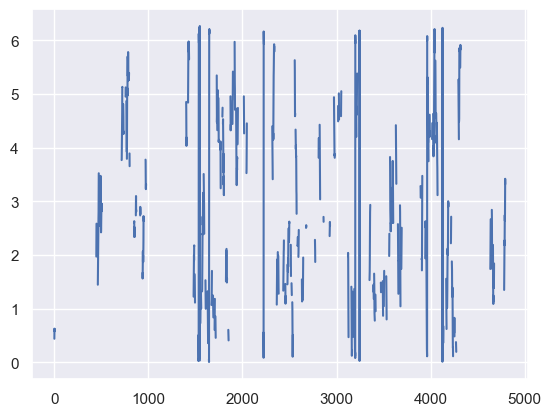

In [135]:
size = 5000
plt.plot(np.arange(size), headAngel[:size])
plt.show()

One fix is to simply remove the missing points. The following plots are done with this approach

The head angel data is given in radients. This causes discontinuity at angel 0, since the radiant jumps from $2\pi$ to 0. To illustrate this, we plot the first 300 time steps of the head data. Also, the missing values causes the curve to jump a lot. 

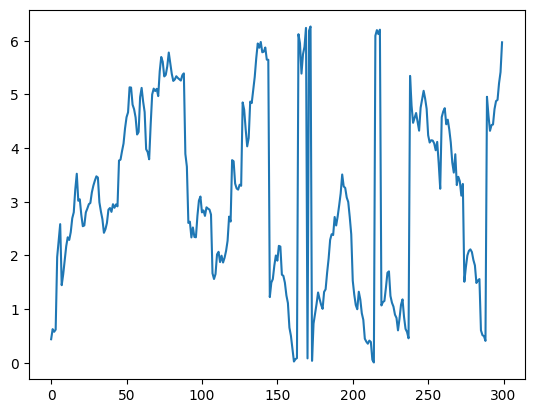

In [46]:
size = 300
headAngel_pure = headAngel[~np.isnan(headAngel)]
plt.plot(np.arange(size), headAngel_pure[:size])
plt.show()

The head angel is contious if given by sine and cosine values. 

In [15]:
sin_arr = np.sin(headAngel_pure)
cos_arr = np.cos(headAngel_pure)

Sine plot

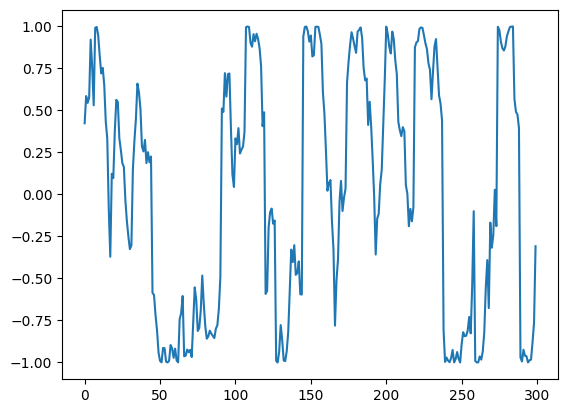

In [47]:
size = 300
plt.plot(np.arange(size), sin_arr[:size])
plt.show()

Cosine plot

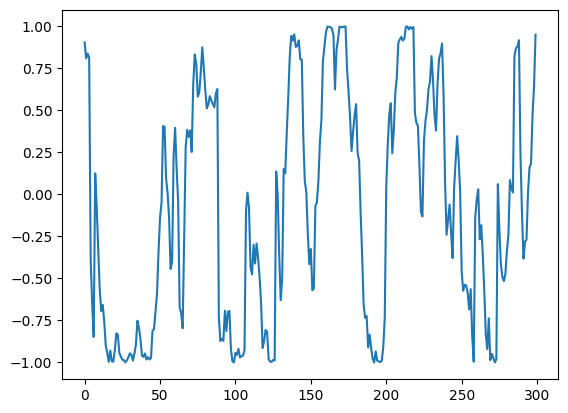

In [48]:
size = 300
plt.plot(np.arange(size), cos_arr[:size])
plt.show()

# Creat dataframe

In [85]:
df = pd.DataFrame({"headAngel":headAngel})
for i in range(celldata.shape[0]):
    name = "cell_"+f"{i}"
    df[name] = celldata[i]
df["sin_angel"] = np.sin(df["headAngel"])
df["cos_angel"] = np.cos(df["headAngel"])
df.head()

,headAngel,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,...,cell_63,cell_64,cell_65,cell_66,cell_67,cell_68,cell_69,cell_70,sin_angel,cos_angel
0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN
1,0.437650,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.423812,0.905750
2,0.625708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.585671,0.810549
3,0.576386,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.544997,0.838438
4,0.616171,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.577915,0.816097


## Split into train, test and validation set

In [218]:
tot_len = df.shape[0]
train_len = round(tot_len*0.5)
val_len = round(tot_len*0.8)

ind = np.arange(tot_len)
train_ind = ind[:train_len]
val_ind = ind[train_len:val_len]
test_ind = ind[val_len:]

In [222]:
df_train = df.loc[train_ind]
df_val = df.loc[val_ind]
df_test = df.loc[test_ind]

# Fill missing data

## Simple methods

In [223]:
# Interpolation
df_train["interpolated_angel"] = df_train["headAngel"].interpolate(option = "spline")
# Exponential moving average
df_train["ema_angel"] = df_train["headAngel"].ewm(halflife=4).mean()

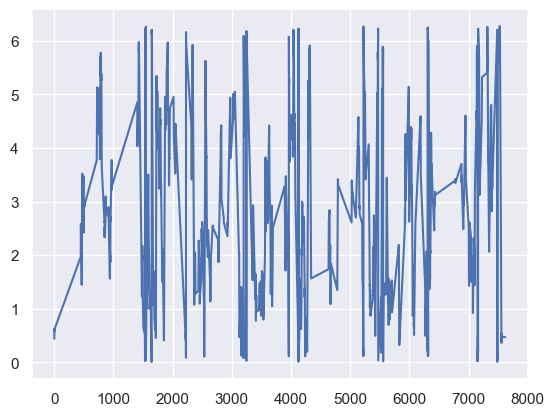

In [225]:
plt.plot(np.arange(train_len), df_train["interpolated_angel"])
plt.show()

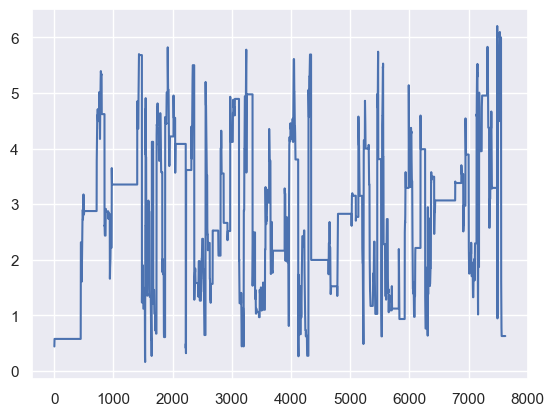

In [226]:
plt.plot(np.arange(train_len), df_train["ema_angel"])
plt.show()

## Gaussian process

In [235]:
df_train["headAngel"].isnull()

0        True
1       False
2       False
3       False
4       False
        ...  
7617     True
7618     True
7619     True
7620     True
7621     True
Name: headAngel, Length: 7622, dtype: bool

In [236]:
missing_head = df_train["headAngel"].isnull()

time_full = np.arange(train_len).reshape(-1,1)
time = time_full[np.invert(missing_head),]
time_continous = np.linspace(start = time_full[0][0], stop = time_full[-1][0], num = 1000)

head_full = np.array(df_train["headAngel"])
head = head_full[np.invert(missing_head)]

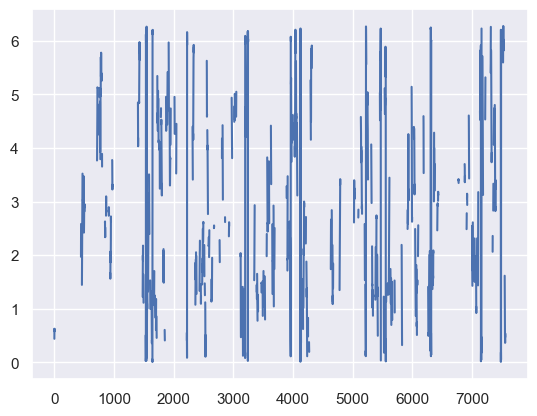

In [244]:
plt.plot(time_full, head_full)
plt.show()

In [248]:
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)

In [249]:
gpr = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=0, normalize_y=True)
gpr.fit(time, head)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1), normalize_y=True)

In [250]:
pred = gpr.predict(time_full)

In [251]:
sample = gpr.sample_y(time_full)

MemoryError: Unable to allocate 443. MiB for an array with shape (7622, 7622) and data type float64

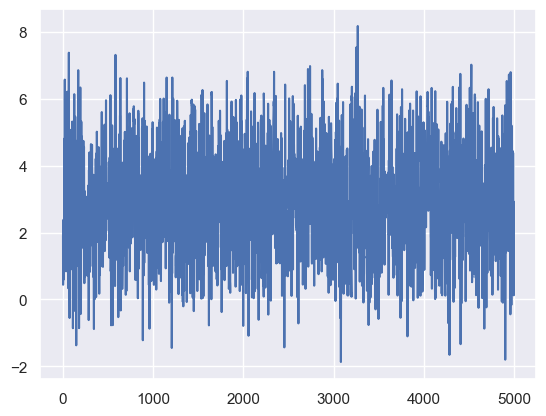

In [ ]:
plt.plot(time_full[:size], sample[:size])
plt.show()

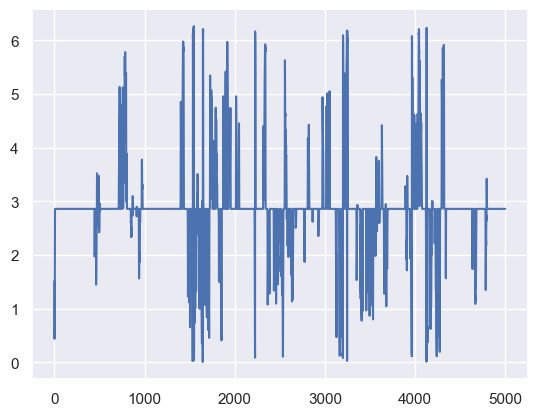

In [252]:
plt.plot(time_full[:size], pred[:size])
plt.show()

### GPflow


In [ ]:
model = gpflow.models.GPR(
    (time, head),
    kernel=gpflow.kernels.SquaredExponential(),
)

NameError: name 'gpflow' is not defined

In [ ]:
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

## MICE

## Simple

In [163]:
df_miss = np.concatenate((head_full.reshape(-1,1), time_full), axis = 1)

imp = IterativeImputer(random_state=0)
X_imp = imp.fit_transform(df_miss)

In [170]:
pred = X_imp.transpose()[0]
pred

array([2.80271557, 0.43765036, 0.62570799, ..., 2.38073996, 2.03880987,
       1.84808667])

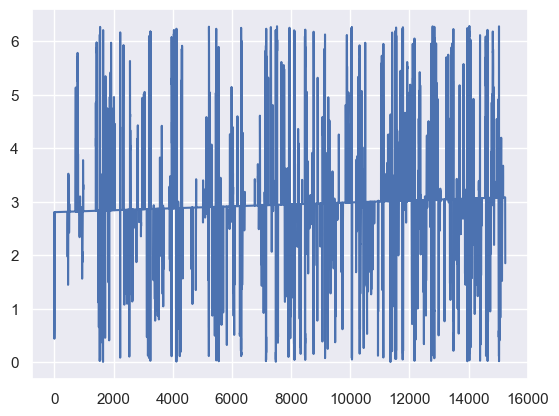

In [172]:
plt.plot(time_full, pred)
plt.show()

## Sliding window

In [173]:
win_size = 90
X = sliding_window_view(df['headAngel'].values, win_size)

X = np.concatenate((X, df.index.values[:len(X)].reshape(-1,1)), axis=1)

imp = IterativeImputer(random_state=0)
X_imp = imp.fit_transform(X)

(15154, 90)


In [190]:
matrix = X_imp[:,range(win_size)]
diags = [matrix[::-1,:].diagonal(i) for i in range(-matrix.shape[0]+1,matrix.shape[1])]

train = pd.DataFrame({"y" : df['headAngel'].values})

train['y_mean'] = np.nan
train['y_std'] = np.nan

for i,v in enumerate(diags):
    train.iloc[i,1] = np.mean(v)
    train.iloc[i,2] = np.std(v) 


In [194]:
train.shape

(15243, 3)

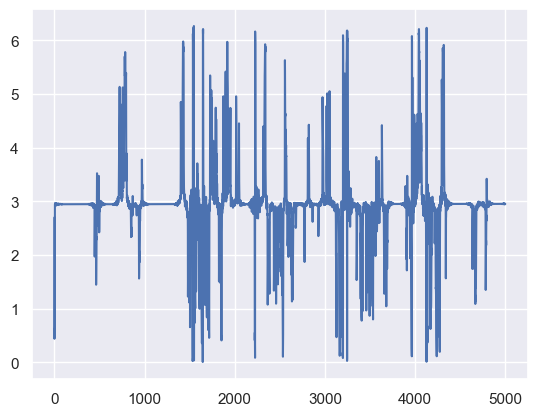

In [197]:
size = 5000
plt.plot(time_full[:size], train["y_mean"][:size])
plt.show()